### Normalize - Test runs only on cdt laptop
Try normalizing the files in singapore 50 that I have brain extracted and normalized.

can modify from the code in the gp repo, but note that they normalize per slice, and I should have an option to simple normalize the whole scan as well as otherwise there are inconsistencies between the slices which will not be ideal for doing 3D training.

load img, get brain mean, get brain std, z score.
Once I have done all these things I can see if my resampled and normalized brains look like their resampled and normalized brains.

nearly there.

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import nibabel as nib
import random

In [7]:
# paths to my example:
source_folder = "/media/benp/NVMEspare/datasets/MRI_IP_project/WMH_challenge_dataset/public/Singapore/50/"
bet_folder = "/media/benp/NVMEspare/datasets/preprocessing_attempts/wmh/singapore/50/"
bet_pre = bet_folder + "pre/"
bet_orig = bet_folder + "orig/"
source_pre = source_folder + "pre/"
source_orig = source_folder + "orig/"
folder_map = {"source/pre":source_pre, "source/orig":source_orig, "bet/pre":bet_pre, "bet/orig":bet_orig}

In [8]:
# resampled flair:
res_flair = bet_folder + "FLAIR_resampled.nii.gz"

### loading and playing around with image

In [12]:
def load_img(filename):
    img_obj = nib.load(filename)
    image_data = img_obj.get_fdata()
    image_header = img_obj.header
    return image_data

In [245]:
img = load_img(res_flair)

In [246]:
img.shape, img.reshape(1, -1).shape

((256, 232, 48), (1, 2850816))

### mean and deviation

In [86]:
def get_brain_mean_std(whole_img3D, cutoff=0.01):
    """
        get mean and starndard deviation of the brain pixels, 
        where brain pixels are all those pixels that are > cutoff 
        in intensity value.
        returns the mean, the std and the locations where the brain is present.
    """
    brain_locs = whole_img3D > cutoff # binary map, 1 for included
    brain3D = whole_img3D[brain_locs]
    
    mean = np.mean(brain3D)
    std = np.std(brain3D)
    
    return mean, std, brain_locs

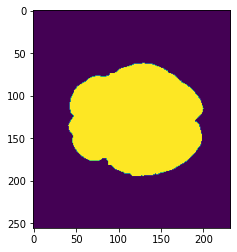

In [233]:
plt.imshow(img[:,:,20]>0.01)


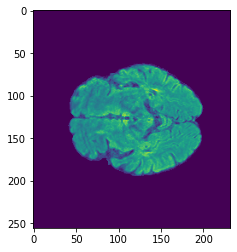

In [234]:
plt.imshow(img[:,:,20])

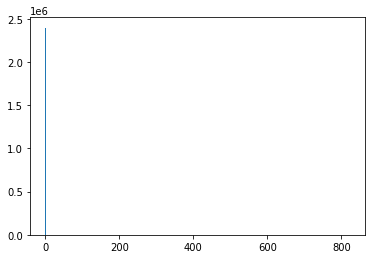

In [43]:
plt.hist(img.reshape(-1,1), bins=1000)
plt.show()

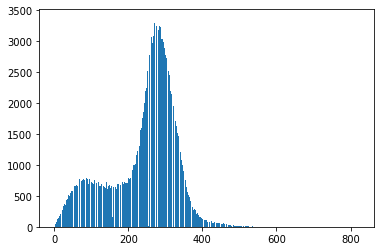

In [85]:
plt.hist(img[img > 0.01].reshape(-1,1), bins=1000)
plt.show()

### Z score
literally just normalize by subtract mean and divide by standard deviation... Should we be doing a more complex normalization to deal with the pixel intensities, I am not sure.... you just compute the overall pixel mean and deviation and apply it across the whole image...
Ah okay, so its basically, you normalize only the parts of the brain that are scan, and not the parts that are not brain, - im not sure if that is actually th correct interpretation according to the cited paper: 
'Comparison between intensity normalization techniques for dynamic susceptibility contrast (DSC)-MRI estimates of cerebral blood volume (CBV) in human gliomas'
but it is what they did in the group project and my code clearly matches their code below

In [247]:
def normalize_brain(whole_img3D, cutoff=0.01):
    mean, std, brain_locs = get_brain_mean_std(whole_img3D, cutoff)
    whole_img3D[brain_locs] = (whole_img3D[brain_locs] - mean) / std

### Compare the actual preprocessed scan to my preprocessed scan
so when comparing to normal_resample (which seems to be named the wrong way around)
mine is very close to theirs, (while many pixels disagree they disagree by a tiny margin)
and the effect seems to be to do with how the brain extraction software has worked (BET), with everything else very very close. So I'm happy to procede and turn this into a script but maybe need to experiment with the effect of Bet on the image.

In [248]:
img_copy2 = np.copy(img)
normalize_brain(img_copy2, cutoff=0.1)

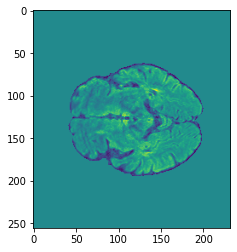

In [249]:
plt.imshow(img_copy2[:,:,20])

In [273]:
# load the actually preprocessed image:
prepped_file1 = "/media/benp/NVMEspare/datasets/MRI_IP_project/grpproj_WMH_preprocessed/challenge_extract_normal_resample/Singapore/imgs/50_FLAIR.nii.gz"
prepped_file2 = "/media/benp/NVMEspare/datasets/MRI_IP_project/grpproj_WMH_preprocessed/challenge_extract_resample_normal/Singapore/imgs/50_FLAIR.nii.gz"
prepped_img1 = load_img(prepped_file1)
prepped_img2 = load_img(prepped_file2)

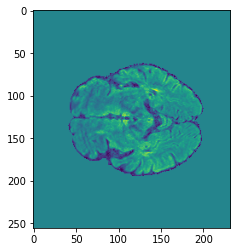

In [274]:
plt.imshow(prepped_img[:,:,20])

#### proportion and total of voxels that disagree, across the whole scan

In [275]:
np.sum(prepped_img1 != img_copy2) / np.prod(prepped_img1.shape), np.sum(prepped_img1 != img_copy2)

(0.6672696519172054, 1902263)

In [276]:
np.sum(prepped_img2 != img_copy2) / np.prod(prepped_img2.shape), np.sum(prepped_img2 != img_copy2)

(0.6621325262661638, 1887618)

#### the total difference between my img and the two types of preprocessed image

In [289]:
np.sum(np.abs(prepped_img1 - img_copy2))

44.37563902182342

In [279]:
np.sum(np.abs(prepped_img2 - img_copy2))

29787.592348148093

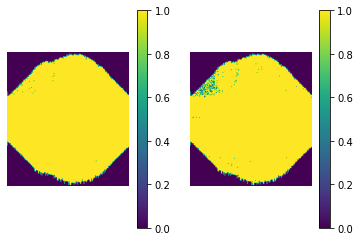

In [285]:
# where does my preprocessing not match their preprocessing exactly?
plt.subplot(1,2,1)
plt.imshow((prepped_img1 != img_copy2)[:,:,20])
plt.axis(False)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((prepped_img2 != img_copy2)[:,:,20])
plt.axis(False)
plt.colorbar(); plt.show()

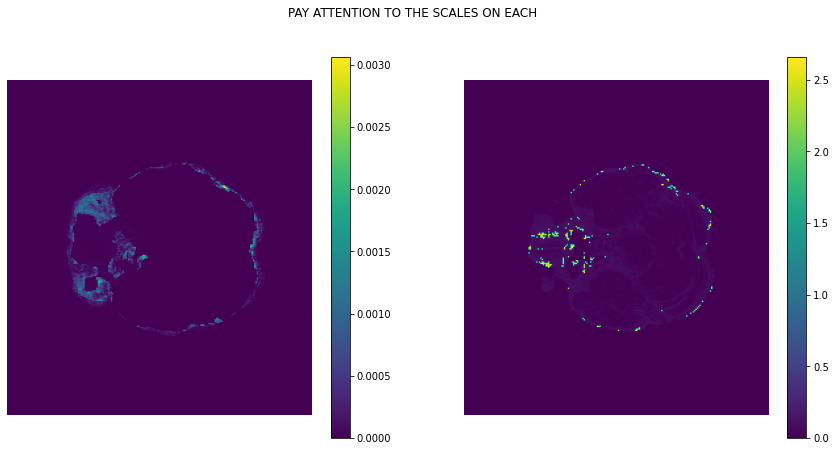

In [305]:
# by now much does my preprocessing not match their preprocessing?
plt.figure(figsize=(15,7))
islice=15
plt.subplot(1,2,1)
plt.imshow(np.abs(prepped_img1 - img_copy2)[:,:,islice])
plt.axis(False)
plt.colorbar()
# by now much does my preprocessing not match their preprocessing?
plt.subplot(1,2,2)
plt.imshow(np.abs(prepped_img2 - img_copy2)[:,:,islice])
plt.axis(False)
plt.colorbar()
plt.suptitle("PAY ATTENTION TO THE SCALES ON EACH"); plt.show()

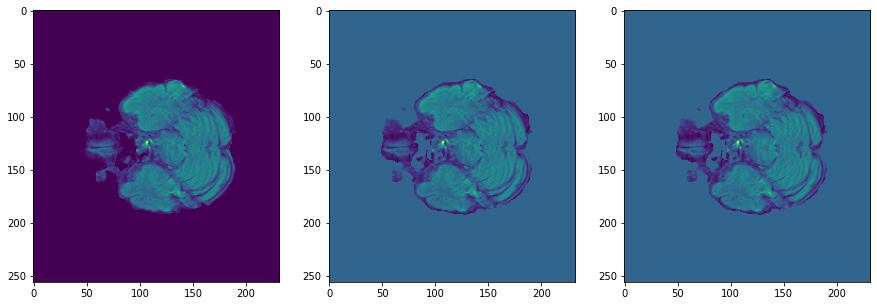

In [311]:
# original, my preprocessing, their preprocessing
islice2=15
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img[:,:,islice2])
plt.subplot(1,3,2)
plt.imshow(img_copy2[:,:,islice2])
plt.subplot(1,3,3)
plt.imshow(prepped_img1[:,:,islice2])
plt.show()

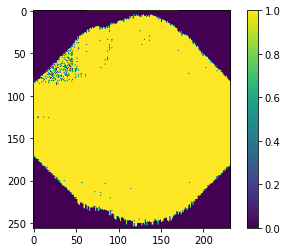

In [235]:
plt.imshow((prepped_img != img)[:,:,20])
plt.colorbar()

### Compare that my code does the same as the group project code:
yes it does but their code is v v v v slow for some reason.
checking that my code matches now matches the code given to me in the folder....

In [130]:
# the section below is lifted from the group project code.
def get_brain_mean(all_slices):
    als = all_slices.reshape(1, -1)
    collect = []
    for index, element in enumerate(als[0]):
        if element >= 0.1:
            collect.append(element)
    collect = np.array(collect)
    mean = np.mean(collect)
    return mean


def get_brain_std(all_slices):
    als = all_slices.reshape(1, -1)
    collect = []
    for index, element in enumerate(als[0]):
        if element >= 0.1:
            collect.append(element)
    collect = np.array(collect)
    std = np.std(collect)
    return std


def z_score(all_slices):
    brain_mean = get_brain_mean(all_slices)
    brain_std = get_brain_std(all_slices)
    all_slices_z = []
    for index, sli in enumerate(all_slices):
        length = int(sli.shape[0])
        width = int(sli.shape[1])
        sli_check = sli.reshape(1, -1)
        kuma = []
        for ind, ele in enumerate(sli_check[0]):
            if (ele >= 0.1):
                modi = (ele - brain_mean) / brain_std
                kuma.append(modi)
            else:
                kuma.append(ele)
        kuma = np.array(kuma)
        kuma = kuma.reshape(length, width)
        all_slices_z.append(kuma)
    all_slices_z = np.array(all_slices_z)
    all_slices_z = all_slices_z.swapaxes(0, 2)
    all_slices_z = all_slices_z.swapaxes(0, 1)
    return all_slices_z

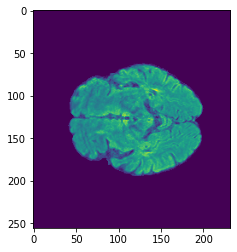

In [131]:
plt.imshow(img[:,:,20])

In [163]:
img_copy = np.copy(img)

In [164]:
normalize_brain(img_copy)

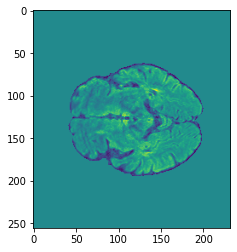

In [165]:
plt.imshow(img_copy[:,:,20])

In [166]:
their_img = z_score(img)

In [167]:
their_img.shape

(232, 48, 256)

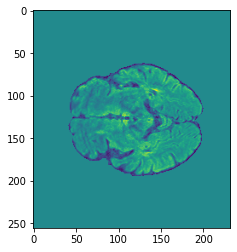

In [168]:
plt.imshow(their_img[:,20,:].T)

In [172]:
# yes every slice is identical
for i in range(48):
    print(np.sum(their_img[:,i,:].T - img_copy[:,:,i]), end=" ")

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

In [236]:
img_copy[:,:,20] - their_img[:,20,:].T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [237]:
their_img.T.shape

(256, 48, 232)

In [238]:
img.shape

(256, 232, 48)

In [239]:
their_img.shape

(232, 48, 256)